**Reference:** 

[1] ISMRM tutorial - Structural connectome for Human Connectome Project (HCP)
https://mrtrix.readthedocs.io/en/latest/quantitative_structural_connectivity/ismrm_hcp_tutorial.html

[2] https://github.com/BrainModes/tvb-pipeline-sc/blob/master/mrtrix3_connectome.py


# **Requirements**

**Required Software or Toolbox**

1. FSL.
2. Freesurfer
3. mrtrix3

**Diffusion preprocessed files**

1. B_VALUE_PATH: bvals # How large of a diffusion gradient was applied to the data.
2. B_VECTOR_PATH: bvecs # What directions the gradients were applied.
3. DTI_PATH: data.nii.gz (Preprocessed DTI)
4. NODIF_BRAIN_MASK_PATH: nodif_brain_mask.nii.gz

**Structural preprocessed files**

1. T1_PATH: T1w_acpc_dc_restore_brain.nii.gz


**Atlas in MNI152 space**
1. aal atlas
2. brainnetome atlas
3. ...

# **Main Steps in processing DTI data.**

**Structural image processing** 

1. Generate a tissue-segmented image (five-tissue-type (5TT)) appropriate for Anatomically-Constrained Tractography:

In [ ]:
5ttgen fsl  T1_PATH  TT_mif -premasked

Note: 

MIF: mrtrix image format

**Diffusion image processing**

1. Convert the diffusion images into a non-compressed format (not strictly necessary, but will make subsequent processing faster), embed the diffusion gradient encoding information within the image header, re-arrange the data strides to make volume data contiguous in memory for each voxel, and convert to floating-point representation (makes data access faster in subsequent commands)



In [ ]:
mrconvert DTI DWI_MIF -fslgrad B_VECTOR B_VALUE -datatype float32 -strides 0,0,0,1

2. Generate a mean b=0 image (useful for visualisation):


In [ ]:
dwiextract DWI_MIF - -bzero -nthreads 4 -force | mrmath - mean MeanB0_mif -axis 3 


3. Estimate the response function

Usage:

dwi2response algorithm [ options ] ...

dwi2response msmt_5tt input in_5tt out_wm out_gm out_csf [ options ]

In [ ]:
dwi2response msmt_5tt DWI_MIF TT_mif WM_Response GM_Response CSF_Response -voxels RF_Voxels_mif 

4. Perform Multi-Shell, Multi-Tissue Constrained Spherical Deconvolution


In [ ]:
dwi2fod msmt_csd DWI_MIF WM_Response WM_FOD GM_Response GM_FOD CSF_Response CSF_FOD -mask NODIF_BRAIN_MASK 

**Connectome generation**

1. Generate the initial tractogram 

In [ ]:
tckgen WM_FOD tractogram_filepath -act TT_mif -backtrack -crop_at_gmwmi -maxlength 250 -select num_streamlines -seed_dynamic WM_FOD -cutoff 0.06 -nthreads 4 -force

2. use sift2 to determine streamline weights
    

In [ ]:
tcksift2 tractogram_filepath WM_FOD Weights_CSV -act TT_mif -out_mu MU_txt -fd_scale_gm -nthreads 4 -force

**Map streamlines to the parcellated image to produce a connectime**

1. Subject space to MNI152 standard space


In [ ]:
mrhistmatch linear T1_PATH template_image_path -nthreads 4 -force -mask_input T1_mask_mif -mask_target template_mask_path

2. flirt and fnirt registration

In [ ]:
flirt -ref flirt_ref_path -in flirt_in_path -omat T1_to_template -dof 12 -cost leastsq

fnirt --config=fnirt_config_basename --ref=fnirt_ref_path --in=fnirt_in_path --aff=T1_to_template --refmask=fnirt_ref_mask_path --inmask=fnirt_in_mask_path --cout=T1_to_template_warpcoef
    

3. Calculate the transform matrix from template space to subject space

invwarp --ref=T1_histmatch --warp=T1_to_template_warpcoef --out=template_to_T1_warpcoef

4. Transform atlas parcellation to subject space

In [ ]:
applywarp --ref=T1_histmatch --in=parc_image_path_aal --warp=template_to_T1_warpcoef --out=aal_atlas_transformed --interp=nn

labelconvert aal_atlas_transformed parc_lut_file_aal mrtrix_lut_file_aal aal_parc

5. Generate the connectome in corresponding atlas


In [ ]:
tck2connectome tractogram_filepath aal_parc AAL_Connectome -tck_weights_in Weights_CSV -symmetric

# **The generated SC**

In [ ]:
!pip install nilearn

/home/lzc/miniconda3/envs/zhichao/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


Text(0.5, 1.0, 'Normalized SC')

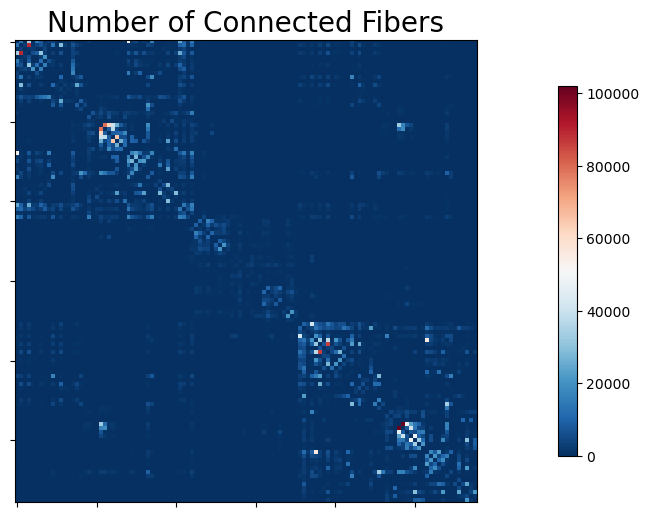

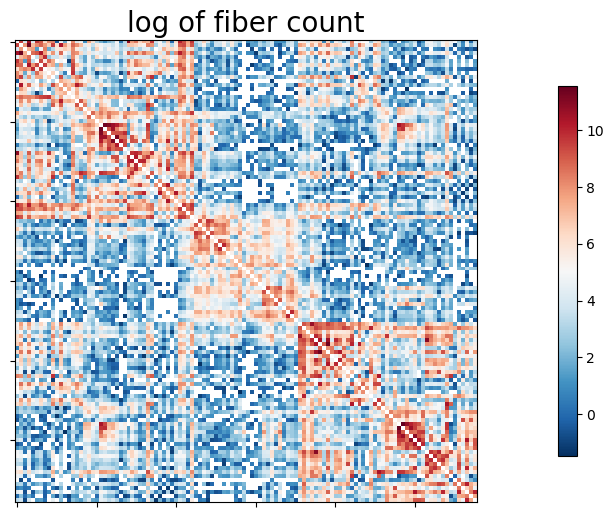

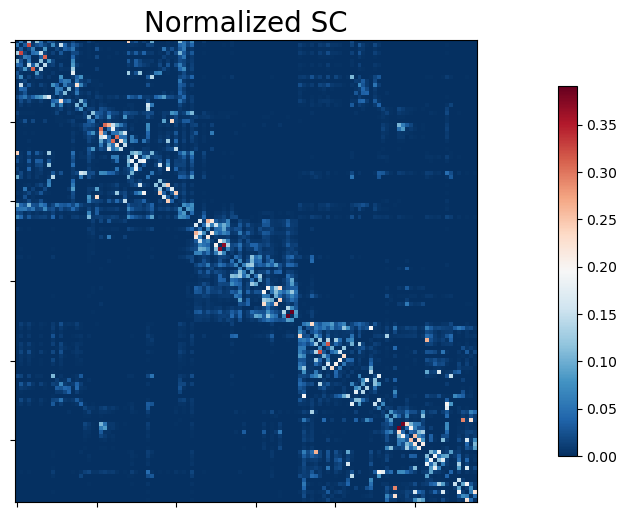

In [2]:
import pandas as pd
import numpy as np
import os

aal_sc_path='./data/aal_connectome.csv'
sc=np.array(pd.read_csv(aal_sc_path,header=None))

from nilearn import plotting
# Mask out the major diagonal
np.fill_diagonal(sc, 0)

degree_of_sc=np.diag(np.power(np.sum(sc,0),-0.5))
normalized_sc=np.matmul(np.matmul(degree_of_sc,sc),degree_of_sc)

import matplotlib.pyplot as plt 
fig,ax=plt.subplots(1,1,figsize=(10,6))
plotting.plot_matrix(sc, labels=None, colorbar=True,axes=ax)
plt.title('Number of Connected Fibers',fontsize=20)

fig,ax=plt.subplots(1,1,figsize=(10,6))
plotting.plot_matrix(np.log(sc), labels=None, colorbar=True,axes=ax)
plt.title('log of fiber count',fontsize=20)

fig,ax=plt.subplots(1,1,figsize=(10,6))
plotting.plot_matrix(normalized_sc, labels=None, colorbar=True,axes=ax)
plt.title('Normalized SC',fontsize=20)


# **Other platform for generating structural connectome:**
[1] Connectome Mapper 3: https://connectome-mapper-3.readthedocs.io/en/latest/

[2] DIPY: https://dipy.org/
